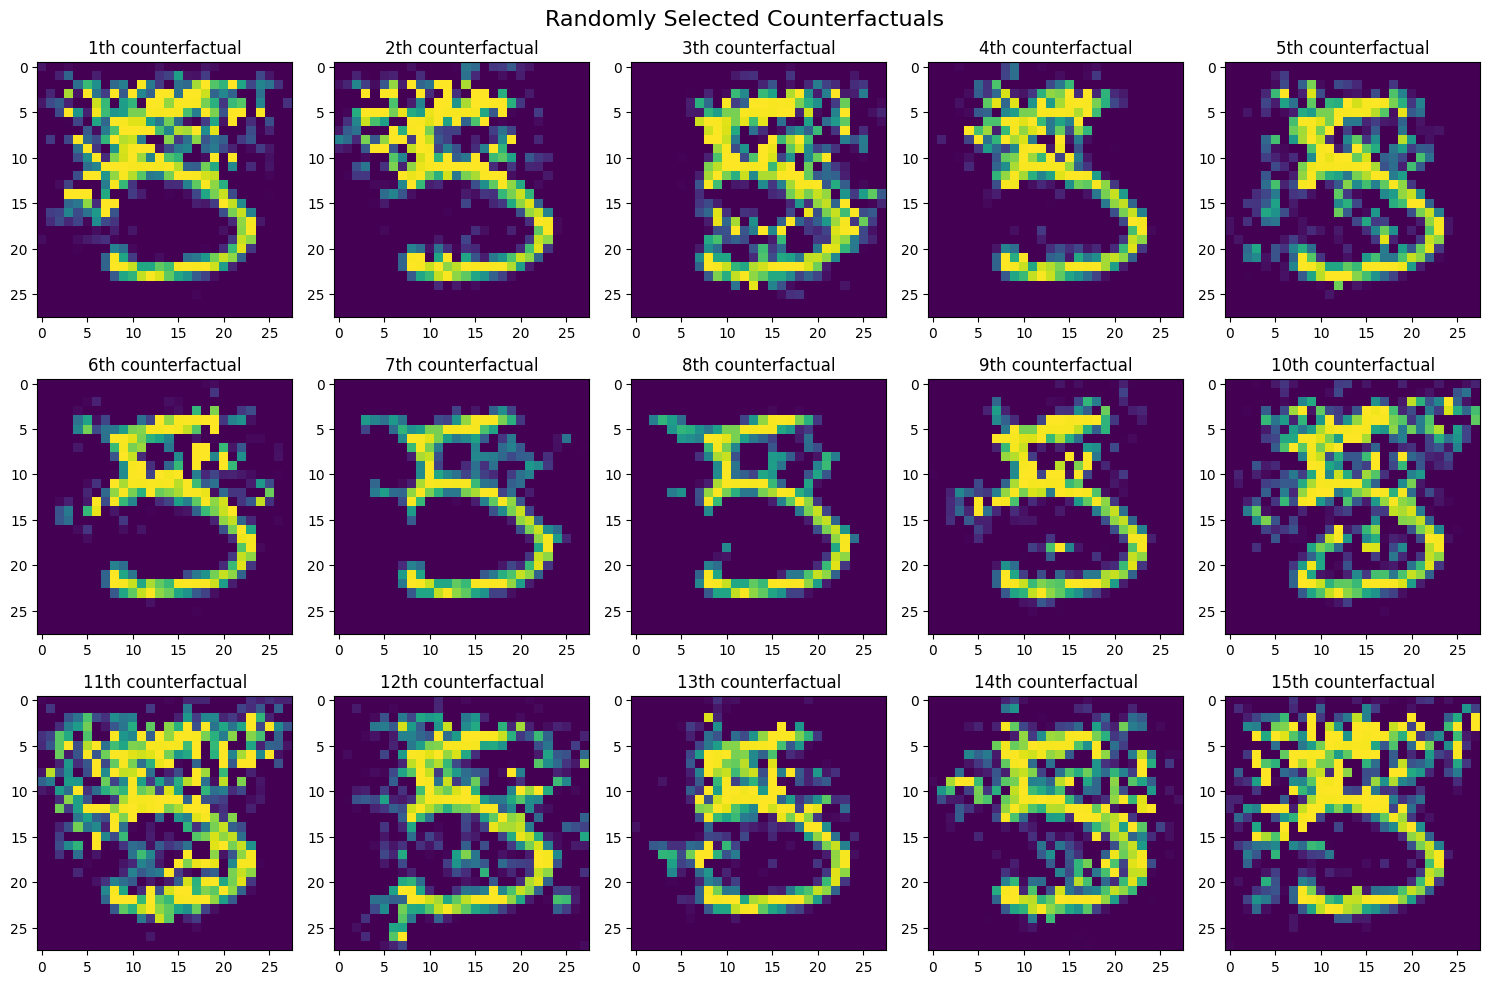

In [69]:
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel(40)  
tf.compat.v1.disable_v2_behavior()  
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import numpy as np
from skimage import io
import os
from alibi.explainers import CEM

from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
import torch
import ot
import shap

df = pd.read_excel("all_results_PN.xlsx")
all_results_flat = df.values

import random
fig, ax = plt.subplots(3, 5, figsize=(15, 10)) 
k=0
random_integers = random.sample(range(0, 100), 15)

for i in range(0,3):
    for j in range(0, 5):
        ax[i,j].imshow(all_results_flat[random_integers[k]].reshape(28,28)) 
        ax[i,j].set_title(f"{k+1}th counterfactual")  
        k += 1
fig.suptitle("Randomly Selected Counterfactuals", fontsize=16)
plt.tight_layout()
plt.show()  


x_train shape: (60000, 28, 28) y_train shape: (60000,)
(10000, 28, 28)
x_train shape: (60000, 784) x_test shape: (10000, 784)
y_train shape: (60000, 10) y_test shape: (10000, 10)
The index with the least number of changed pixels is: 0
The number of pixels changed in this image is: 101.0


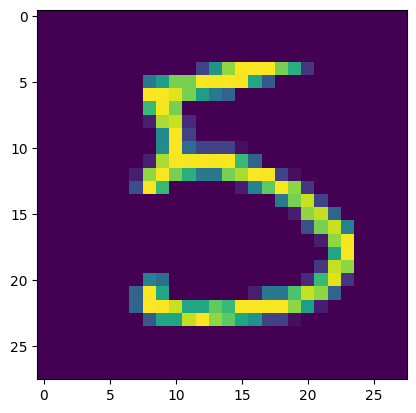

In [70]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
print(x_test.shape)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape(60000,784,)
x_test = x_test.reshape(10000,784,)
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin
x_train_flat = x_train.reshape(-1, 784)  

x_test_flat = x_test.reshape(-1, 784)  

idx = 15
X = x_test_flat[idx].reshape(1, 784)

plt.imshow(X.reshape(28, 28));

Cik = np.zeros((100, 784))
for i, r in enumerate(all_results_flat):
    Cik[i] = (X != r).astype(int)
unchanged_pixels = np.all(Cik == 0, axis=0) 
changed_pixels = np.any(Cik == 1, axis=0) 

# Calculate the number of changed pixels for each image in Cik
num_changed_pixels = np.sum(Cik, axis=1)

# Find the index of the image with the least number of changed pixels
min_changed_index = np.argmin(num_changed_pixels)

# Find the number of changed pixels for this index
min_changed_pixels = num_changed_pixels[min_changed_index]

print(f"The index with the least number of changed pixels is: {min_changed_index}")
print(f"The number of pixels changed in this image is: {min_changed_pixels}")

# 
# X_changed = X[0, changed_pixels] 
# 
# all_results_changed = all_results_flat[:, changed_pixels]  
# 
# print(f"Changed pixels in X: {X_changed.shape}")
# print(f"Changed pixels in all_results: {all_results_changed.shape}")

In [71]:
X_tensor = torch.tensor(X, dtype=torch.float32)
all_results_tensor = torch.tensor(all_results_flat, dtype=torch.float32)
print(X_tensor.size(),all_results_tensor.size())

torch.Size([1, 784]) torch.Size([100, 784])


## Lock the unchanged pixel location and value by thresholding

## Finding the most diverse counterfactuals

Most diverse images are at indices: [29 97 98 73 64 81 86 91 77 89]


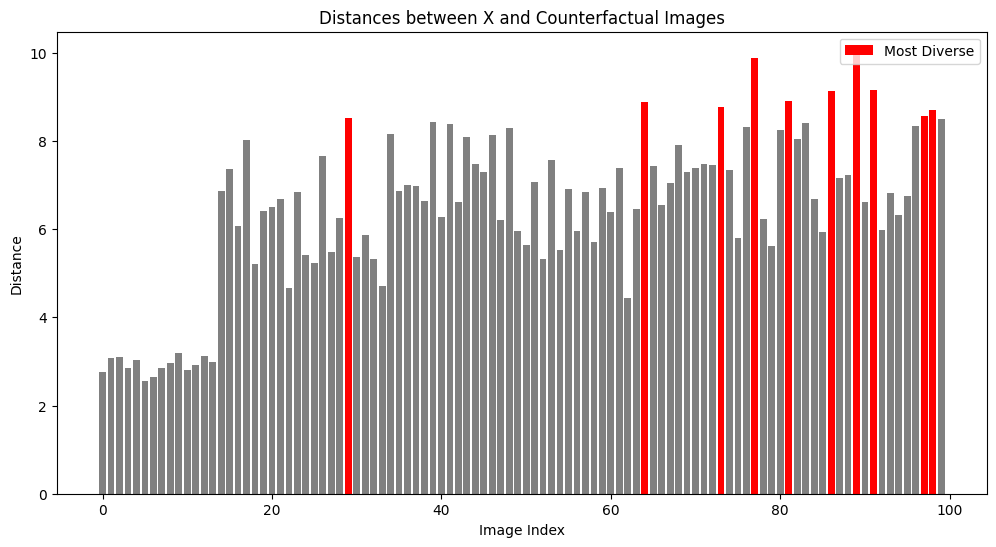

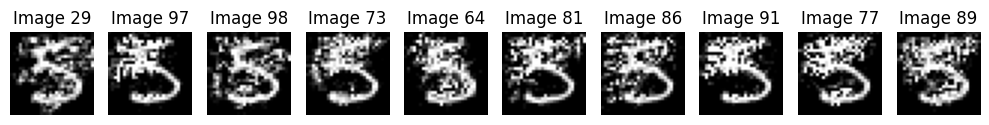

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean

def calculate_distances(X, all_results_flat):
    X_flattened = X.flatten()

    distances = np.array([euclidean(X_flattened, img.flatten()) for img in all_results_flat])
    
    return distances

def find_most_diverse_images(distances, top_n=10):
    most_diverse_indices = np.argsort(distances)[-top_n:]  
    
    return most_diverse_indices

def visualize_distances_with_highlights(distances, highlighted_indices):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(distances)), distances, color='gray')
    plt.title("Distances between X and Counterfactual Images")

    # Highlight the most diverse images in red
    for idx in highlighted_indices:
        plt.bar(idx, distances[idx], color='red', label='Most Diverse' if idx == highlighted_indices[0] else "")
    
    plt.xlabel('Image Index')
    plt.ylabel('Distance')
    plt.legend(loc="upper right")
    plt.show()

X_flat = X_tensor.cpu().numpy().flatten()  # Flatten the original image

distances = calculate_distances(X_flat, all_results_flat)

largest_distance_images = find_most_diverse_images(distances, top_n=10)
print("Most diverse images are at indices:", largest_distance_images)

visualize_distances_with_highlights(distances, largest_distance_images)

fig, axes = plt.subplots(1, len(largest_distance_images), figsize=(10, 5))
for i, idx in enumerate(largest_distance_images):
    ax = axes[i]
    ax.imshow(all_results_flat[idx].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Image {idx}")

plt.tight_layout()
plt.show()

The 10 images finded totally changes 663 pixels, which occupies 88% of the total pixels changed(754 pixels) in 100R.

## Finding the one image with largest joint-probability 

In [96]:
import torch
import numpy as np
import ot
import matplotlib.pyplot as plt

class WassersteinDivergence:
    def __init__(self, reg=1):
        self.nu = None
        self.reg = reg

    def distance(self, y_s: torch.tensor, y_t: torch.tensor, weights: torch.tensor, delta):
        if delta < 0 or delta > 0.5:
            raise ValueError("Delta should be between 0 and 0.5")

        y_s = y_s.squeeze()
        y_t = y_t.squeeze()

        y_s_filtered = y_s[weights > 0]
        y_t_filtered = y_t[weights > 0]
        proj_y_s_dist_mass = torch.ones(len(y_s_filtered)) / len(y_s_filtered)
        proj_y_t_dist_mass = torch.ones(len(y_t_filtered)) / len(y_t_filtered)

        trimmed_M_y = ot.dist(
            y_s_filtered.reshape(y_s_filtered.shape[0], 1),
            y_t_filtered.reshape(y_t_filtered.shape[0], 1),
            metric="sqeuclidean",
        ).to("cpu")

        trimmed_nu = ot.emd(proj_y_s_dist_mass, proj_y_t_dist_mass, trimmed_M_y)
        dist = torch.sum(trimmed_nu * trimmed_M_y) * (1 / (1 - 2 * delta))

        return dist

def lock_pixels_if_static_across_all_images(X, most_diverse_images, Thresh=0):
    weights = np.ones(X.shape, dtype=float)
    static_pixels = np.all([(np.abs(X - img.reshape(X.shape)) <= Thresh) 
                            for img in most_diverse_images], axis=0)
    weights[static_pixels] = 0  
    return weights

def compute_joint_distribution_with_weights(X, most_diverse_images, delta=0.1, Thresh=0, reg=1):
    ot_model = WassersteinDivergence(reg=reg)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    
    weights = lock_pixels_if_static_across_all_images(X, most_diverse_images, Thresh)
    weights_tensor = torch.tensor(weights, dtype=torch.float32)

    distances = []

    for R_image in most_diverse_images:
        R_tensor = torch.tensor(R_image, dtype=torch.float32)
        dist = ot_model.distance(X_tensor, R_tensor, weights_tensor, delta)
        distances.append(dist.item())  

    return distances

def softmax(distances, temperature=0.05):
    exp_distances = np.exp(-np.array(distances) / temperature)  
    return exp_distances / np.sum(exp_distances)

X = x_test[idx].reshape(784)  
largest_distance_images_ = np.array([all_results_flat[i].reshape(784) for i in largest_distance_images])  # 展平反事实图像
distances = compute_joint_distribution_with_weights(X, largest_distance_images_, delta=0.1, Thresh=0)
print(distances)
joint_probabilities = softmax(distances, temperature=0.05)

print(f"Joint probabilities with weights: {joint_probabilities}")


0.5
<generator object <genexpr> at 0x0000019D2771B7B0>
[0.14536406099796295, 0.14101336896419525, 0.15770697593688965, 0.14982961118221283, 0.15370944142341614, 0.1520804464817047, 0.16272825002670288, 0.1707572340965271, 0.19582143425941467, 0.1947581022977829]
Joint probabilities with weights: [0.132405   0.14444217 0.10344159 0.12109246 0.11205141 0.11576216
 0.09355801 0.07967867 0.04826554 0.04930298]


In [74]:
sorted_indices = np.argsort(-joint_probabilities)
print("Indices of p from largest to smallest:", sorted_indices)


Indices of p from largest to smallest: [1 0 3 5 4 2 6 7 9 8]


In [75]:

largest_distance_tensor = torch.tensor(largest_distance_images_)

In [76]:
from sklearn.metrics.pairwise import cosine_similarity

X_flat = X_tensor.flatten().numpy()
cosine_similarities = []

for i in range(largest_distance_tensor.shape[0]):
    R_flat = largest_distance_tensor[i].flatten().numpy()
    sim = cosine_similarity(X_flat.reshape(1, -1), R_flat.reshape(1, -1))[0][0]
    cosine_similarities.append(sim)

cosine_p_values = softmax(cosine_similarities, temperature=0.1)

print(f"Cosine similarity-based probabilities: {cosine_p_values}")


Cosine similarity-based probabilities: [0.07647553 0.06983124 0.08336427 0.0837982  0.08598895 0.0874629
 0.10231771 0.09279071 0.14329307 0.17467741]


In [77]:
largest_distance_images_= np.array(largest_distance_images_)

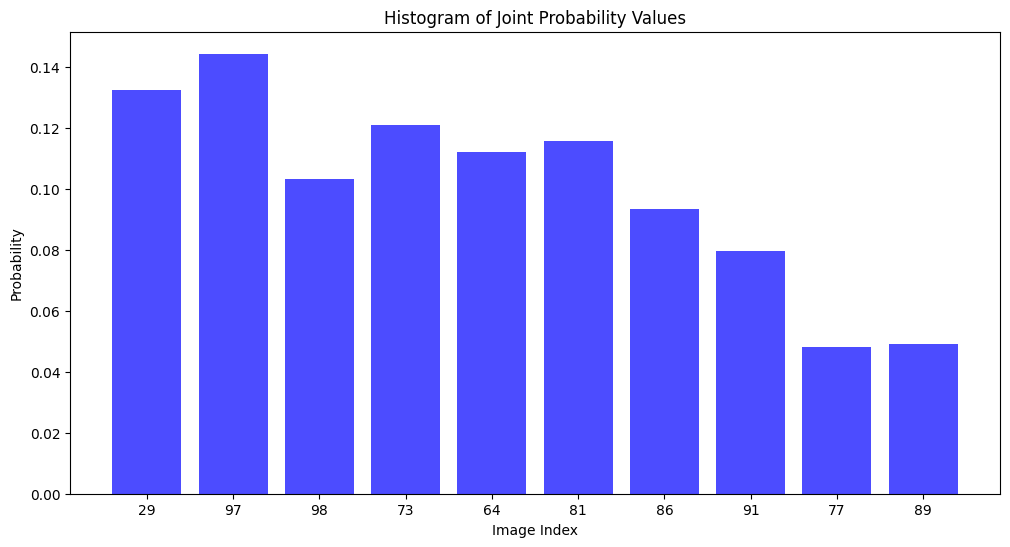

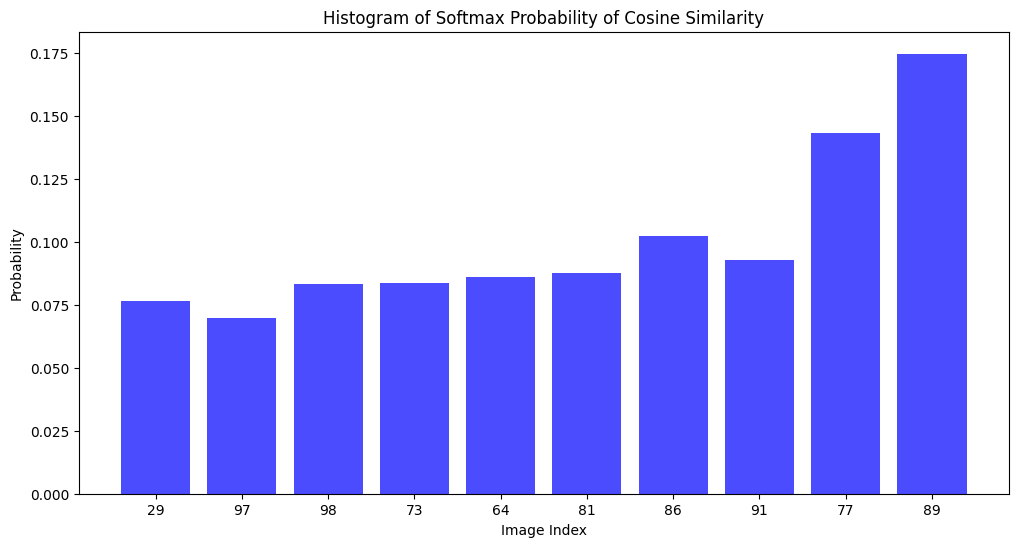

In [78]:
num_images = len(largest_distance_images)
image_indices = np.arange(1, num_images + 1) 

plt.figure(figsize=(12, 6))
plt.bar(image_indices, joint_probabilities, color='blue', alpha=0.7)
plt.xlabel('Image Index')
plt.ylabel('Probability')
plt.title('Histogram of Joint Probability Values')
plt.xticks(image_indices, largest_distance_images)  
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(image_indices, cosine_p_values, color='blue', alpha=0.7)
plt.xlabel('Image Index')
plt.ylabel('Probability')
plt.title('Histogram of Softmax Probability of Cosine Similarity')
plt.xticks(image_indices, largest_distance_images) 
plt.show()


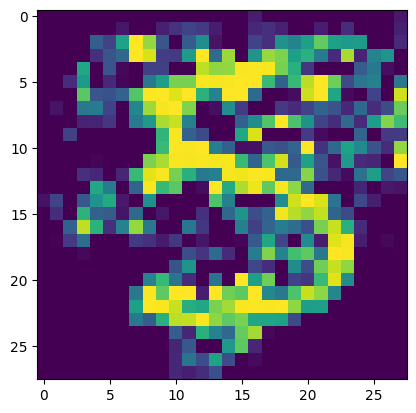

In [79]:
largest_distance_images_ = [all_results_flat[largest_distance_images[i]].reshape(28,28) for i in range(0,len(largest_distance_images))]
plt.imshow(largest_distance_images_[0])
plt.show()

0.9999999999999999


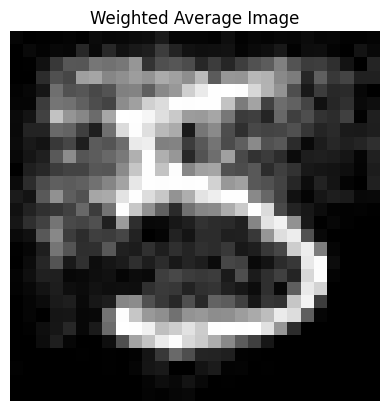

In [80]:
def create_weighted_image(largest_distance_images_, joint_probabilities):

    joint_probabilities = joint_probabilities / np.sum(joint_probabilities)
    print(joint_probabilities.sum())  
    weighted_image = np.zeros((28, 28))  

    for i in range(len(largest_distance_images_)):
        weighted_image += largest_distance_images_[i] * joint_probabilities[i]
    
    return weighted_image

largest_distance_images_reshaped = np.array([img.reshape(28, 28) for img in largest_distance_images_])

weighted_image = create_weighted_image(largest_distance_images_reshaped, joint_probabilities)

plt.imshow(weighted_image, cmap='gray')
plt.title('Weighted Average Image')
plt.axis('off')
plt.show()


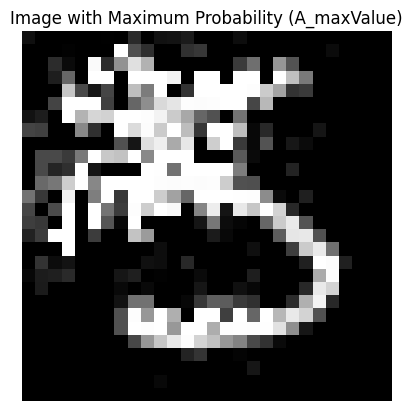

In [81]:
def create_max_image(largest_distance_images_, joint_probabilities):

    largest_distance_images_ = np.array(largest_distance_images_)

    max_prob_index = np.argmax(joint_probabilities)

    max_image = largest_distance_images_[max_prob_index]
    
    return max_image

largest_distance_images_reshaped = np.array([img.reshape(28, 28) for img in largest_distance_images_])

max_image = create_max_image(largest_distance_images_reshaped, joint_probabilities)

plt.imshow(max_image, cmap='gray')
plt.title('Image with Maximum Probability (A_maxValue)')
plt.axis('off')
plt.show()


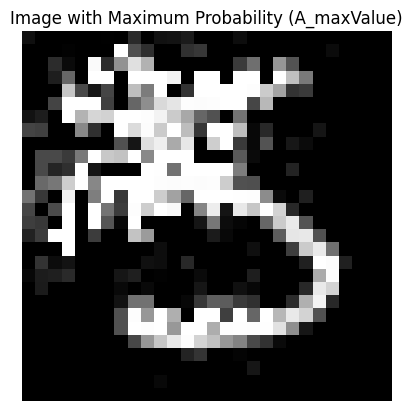

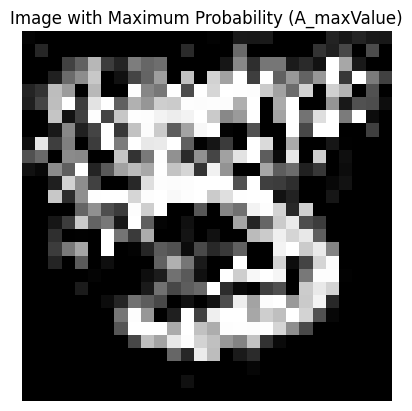

In [82]:
def create_max_image(largest_distance_images_, joint_probabilities):

    largest_distance_images_ = np.array(largest_distance_images_)

    max_prob_index = np.argmax(joint_probabilities)

    max_image = largest_distance_images_[max_prob_index]
    
    return max_image

largest_distance_images_reshaped = np.array([img.reshape(28, 28) for img in largest_distance_images_])

joint_max_image = create_max_image(largest_distance_images_reshaped, joint_probabilities)

plt.imshow(joint_max_image, cmap='gray')
plt.title('Image with Maximum Probability (A_maxValue)')
plt.axis('off')
plt.show()

cos_max_image = create_max_image(largest_distance_images_reshaped, cosine_p_values)

plt.imshow(cos_max_image, cmap='gray')
plt.title('Image with Maximum Probability (A_maxValue)')
plt.axis('off')
plt.show()

361


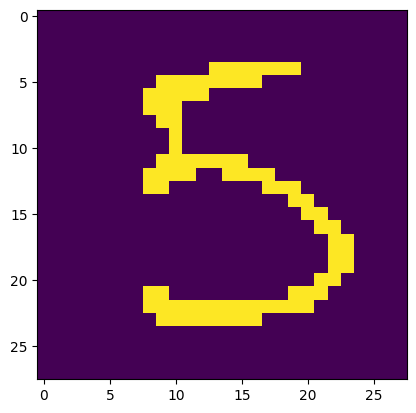

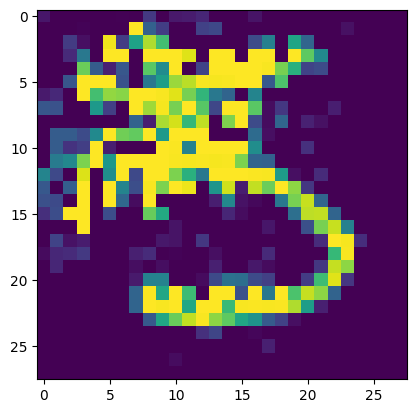

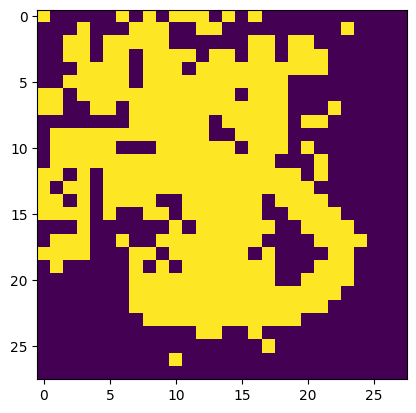

d:\Anaconda\envs\course02502\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


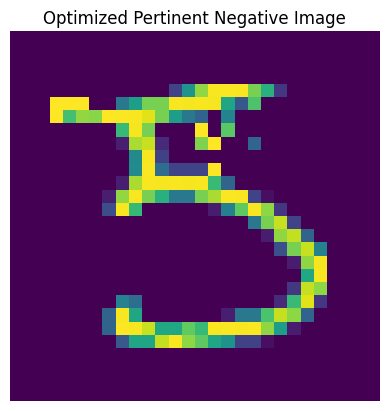

16


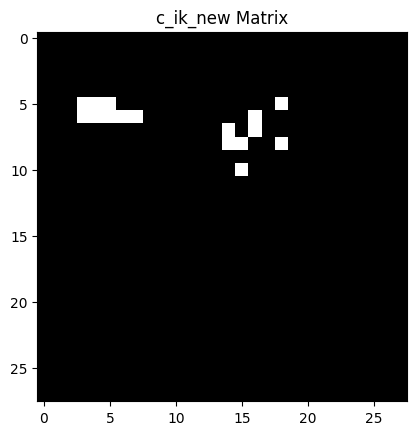

3


In [83]:
cnn = load_model('mnist_cnn.h5')
c_ik = np.where(X.reshape(28,28) != joint_max_image.reshape(28,28), 1, 0)
print(np.sum(c_ik))
PN_optimized1 = joint_max_image.copy()
c_ik_cp = c_ik.copy()  
x_ik = X_tensor.numpy().reshape(28,28) > 0 
plt.imshow(x_ik)
plt.show()

plt.imshow(joint_max_image.reshape(28,28))
plt.show()
plt.imshow(c_ik_cp.reshape(28,28))
plt.show()
X_reshaped = X_tensor.cpu().numpy().reshape(28, 28)  

for i in range(28):
    for j in range(28):
        if c_ik_cp[i, j] == 1:
            PN_temp = PN_optimized1.copy()
            PN_temp[i, j] = X_reshaped[i, j] 
            prediction_temp = cnn.predict(PN_temp.reshape(1, 784))
            if prediction_temp.argmax() == 3:
                PN_optimized1[i, j] = X_reshaped[i, j]  

plt.imshow(PN_optimized1.reshape(28, 28))
plt.title('Optimized Pertinent Negative Image')
plt.axis('off')
plt.show()

c_ik_cp = np.where(X_reshaped != PN_optimized1.reshape(28,28), 1, 0)

changed_pixel_opti = np.sum(c_ik_cp)
print(changed_pixel_opti)
plt.imshow(c_ik_cp.reshape(28,28),cmap='gray')
plt.title('c_ik_new Matrix')
plt.show()
print(cnn.predict(PN_optimized1.reshape(1,784)).argmax())


361


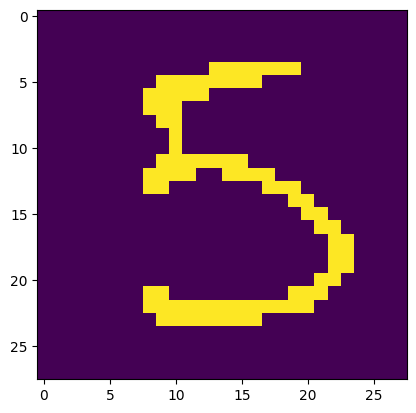

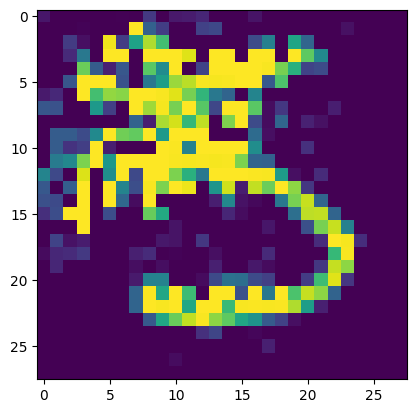

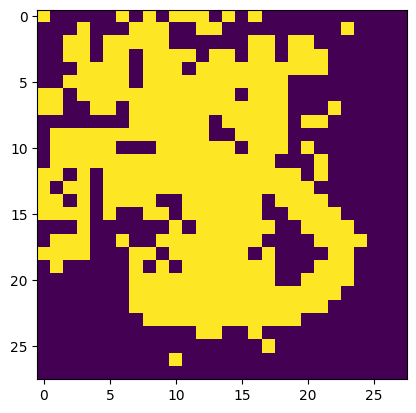

Exception ignored in: <function BaseSession._Callable.__del__ at 0x0000019CBC7DD700>
Traceback (most recent call last):
  File "d:\Anaconda\envs\course02502\lib\site-packages\tensorflow\python\client\session.py", line 1496, in __del__
    if (self._handle is not None and self._session._session is not None and
KeyboardInterrupt: 


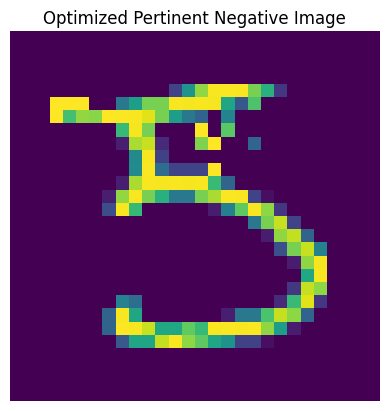

16


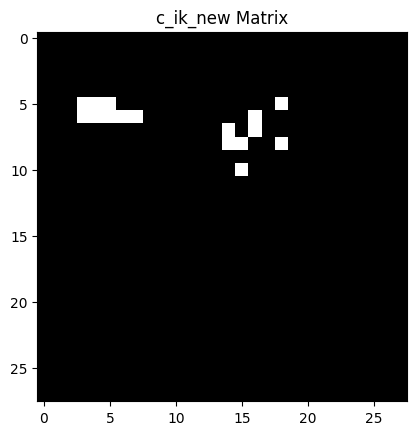

3


In [84]:
cnn = load_model('mnist_cnn.h5')
c_ik = np.where(X.reshape(28,28) != joint_max_image.reshape(28,28), 1, 0)
print(np.sum(c_ik))
PN_optimized1 = joint_max_image.copy()
c_ik_cp = c_ik.copy()  
x_ik = X_tensor.numpy().reshape(28,28) > 0 
plt.imshow(x_ik)
plt.show()

plt.imshow(joint_max_image.reshape(28,28))
plt.show()
plt.imshow(c_ik_cp.reshape(28,28))
plt.show()
X_reshaped = X_tensor.cpu().numpy().reshape(28, 28)  

for i in range(28):
    for j in range(28):
        if c_ik_cp[i, j] == 1:
            PN_temp = PN_optimized1.copy()
            PN_temp[i, j] = X_reshaped[i, j] 
            prediction_temp = cnn.predict(PN_temp.reshape(1, 784))
            if prediction_temp.argmax() == 3:
                PN_optimized1[i, j] = X_reshaped[i, j]  

plt.imshow(PN_optimized1.reshape(28, 28))
plt.title('Optimized Pertinent Negative Image')
plt.axis('off')
plt.show()

c_ik_cp = np.where(X_reshaped != PN_optimized1.reshape(28,28), 1, 0)

changed_pixel_opti = np.sum(c_ik_cp)
print(changed_pixel_opti)
plt.imshow(c_ik_cp.reshape(28,28),cmap='gray')
plt.title('c_ik_new Matrix')
plt.show()
print(cnn.predict(PN_optimized1.reshape(1,784)).argmax())


## Calculating the shap_values based on the counterfacutal R

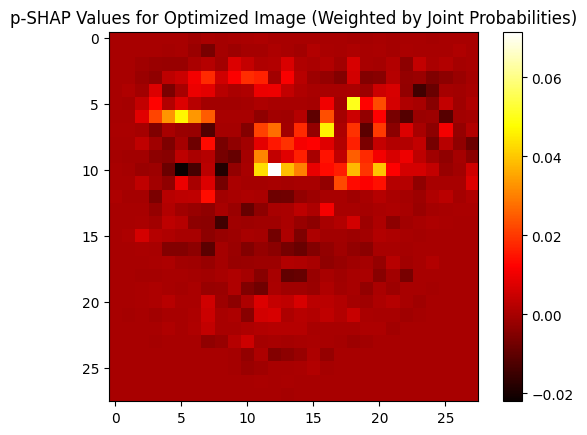

In [23]:
def calculate_p_shap(X, largest_distance_images_, cnn, target_label, joint_probabilities):
    X_reshaped = X.reshape(28, 28)  

    largest_distance_images_ = np.array(largest_distance_images_)
    
    num_counterfactuals = largest_distance_images_.shape[0] 
    joint_probabilities = joint_probabilities / np.sum(joint_probabilities) 

    shap_values = np.zeros((28, 28))  

    for k in range(num_counterfactuals):
        largest_distance_images_reshaped = largest_distance_images_[k].reshape(28, 28) 

        for i in range(28):
            for j in range(28):
                perturbed_image_without = largest_distance_images_reshaped.copy()
                perturbed_image_without[i, j] = X_reshaped[i, j]

                prob_with = cnn.predict(largest_distance_images_reshaped.reshape(1, 784))[0][target_label]
                prob_without = cnn.predict(perturbed_image_without.reshape(1, 784))[0][target_label]

                marginal_contribution = (prob_with - prob_without) * joint_probabilities[k]

                shap_values[i, j] += marginal_contribution

    shap_sum = np.sum(shap_values)
    if shap_sum == 0:
        print("Warning: Sum of SHAP values is zero, applying epsilon for stability.")
        epsilon = 1e-10
        shap_sum = epsilon

    shap_values /= shap_sum  

    return shap_values

X = X_tensor.cpu().numpy()  
p_shap_values = calculate_p_shap(X, largest_distance_images_, cnn, target_label=3, joint_probabilities=joint_probabilities)

plt.imshow(p_shap_values, cmap='hot')
plt.colorbar()
plt.title('p-SHAP Values for Optimized Image (Weighted by Joint Probabilities)')
plt.show()



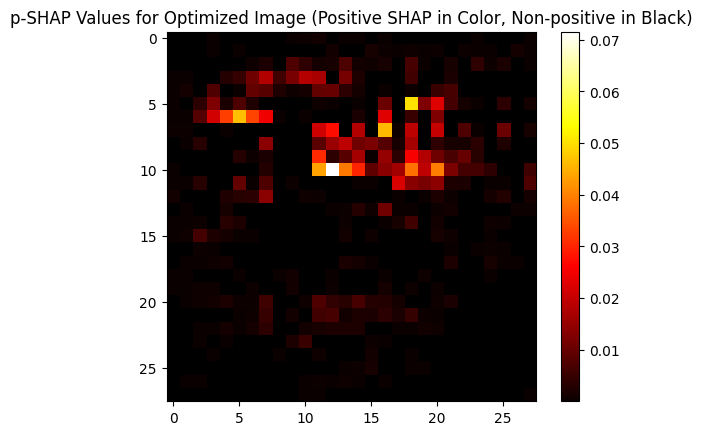

In [24]:
masked_p_shap_values = np.copy(p_shap_values)
masked_p_shap_values[masked_p_shap_values <= 0] = np.nan  

cmap = plt.get_cmap('hot')

cmap.set_bad(color='black')  

plt.imshow(masked_p_shap_values, cmap=cmap, interpolation='none')
plt.colorbar()
plt.title('p-SHAP Values for Optimized Image (Positive SHAP in Color, Non-positive in Black)')
plt.show()

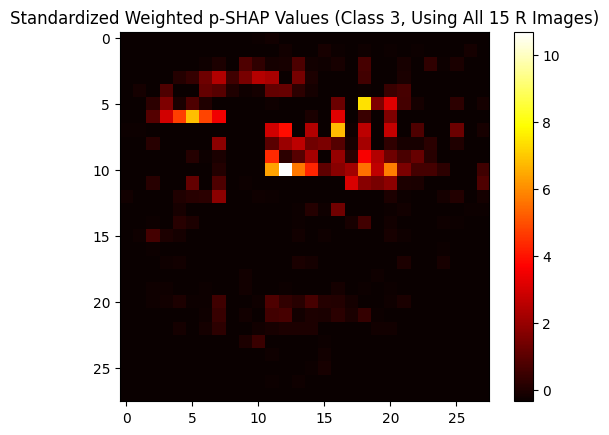

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Replace NaN values with 0 in masked_p_shap_values
masked_p_shap_values = np.nan_to_num(masked_p_shap_values, nan=0)

# Z-score normalization (Standardization) to center around 0 and scale by standard deviation
mean_val = np.mean(masked_p_shap_values)
std_val = np.std(masked_p_shap_values)
normalized_shap_values = (masked_p_shap_values - mean_val) / std_val

# Visualization of normalized SHAP values
plt.imshow(normalized_shap_values.reshape(28, 28), cmap='hot')
plt.colorbar()
plt.title('Standardized Weighted p-SHAP Values (Class 3, Using All 15 R Images)')
plt.show()


In [212]:
# masked_p_shap_values = np.copy(normalized_shap_values.reshape(28,28))

# masked_p_shap_values[masked_p_shap_values < 0] = np.nan  
# print(masked_p_shap_values[15,10])
# cmap = plt.get_cmap('hot')
# cmap.set_bad(color='black')  

# plt.imshow(masked_p_shap_values, cmap=cmap, interpolation='none')
# plt.colorbar()
# plt.title('p-SHAP Values for Optimized Image (Positive SHAP in Color, Non-positive in Black)')
# plt.show()

In [40]:
sorted_shap_values = np.sort(normalized_shap_values, axis=None)[::-1] 

sorted_indices = np.argsort(normalized_shap_values, axis=None)[::-1]  

coordinates = np.unravel_index(sorted_indices, (28, 28)) 

sorted_shap_with_coords = list(zip(sorted_shap_values, zip(coordinates[0], coordinates[1])))

positive_shap_values_with_coords = [(value, coord) for value, coord in sorted_shap_with_coords if value>0]
positive_shap_values_with_coords = positive_shap_values_with_coords[:30]
print(positive_shap_values_with_coords)

for value, coord in positive_shap_values_with_coords:
    print(f"SHAP value: {value:.6f}, Coordinate: {coord}")


[(10.697456033423228, (10, 12)), (7.388872035801238, (5, 18)), (6.827088842009311, (6, 5)), (6.748579372341725, (7, 16)), (6.351344268852287, (10, 11)), (5.748036326717293, (10, 20)), (5.664035056710392, (10, 13)), (5.566217763034283, (10, 18)), (4.8286181058373225, (6, 6)), (4.748174809934722, (6, 4)), (4.403273373429002, (9, 11)), (4.284310611022951, (10, 14)), (3.8935896375152437, (7, 12)), (3.5931923828426466, (9, 18)), (3.5014677411480726, (6, 7)), (3.229222755410079, (6, 16)), (3.182483584005401, (5, 20)), (3.1002788869655777, (11, 17)), (2.9834424170481397, (6, 3)), (2.9301596085245163, (7, 11)), (2.759959656453869, (7, 20)), (2.650551994618632, (10, 19)), (2.6387516814445964, (7, 18)), (2.5984181639229194, (8, 13)), (2.500692033456511, (3, 10)), (2.467266882105354, (7, 14)), (2.4615916968640623, (3, 7)), (2.4293284499208228, (9, 19)), (2.2604771219263275, (3, 11)), (2.2487350841054043, (9, 14))]
SHAP value: 10.697456, Coordinate: (10, 12)
SHAP value: 7.388872, Coordinate: (5, 1

In [41]:
print(np.array(positive_shap_values_with_coords).shape)

(30, 2)


C:\Users\dilar\AppData\Local\Temp\ipykernel_37756\3213037112.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(positive_shap_values_with_coords).shape)


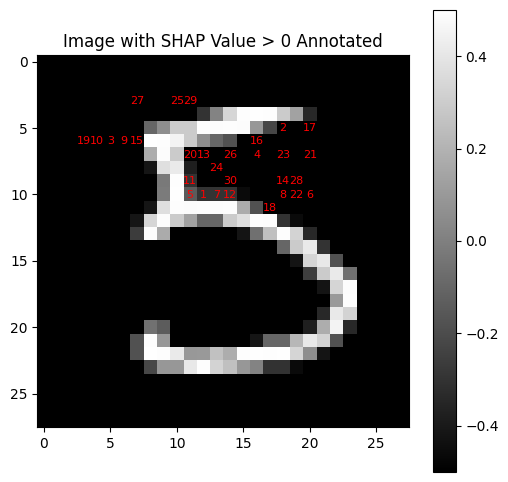

In [42]:
plt.figure(figsize=(6, 6))
plt.imshow(X_reshaped, cmap='gray', interpolation='none')
plt.title('Image with SHAP Value > 0 Annotated')

for rank, (value, (i, j)) in enumerate(positive_shap_values_with_coords):
    plt.text(j, i, str(rank + 1), color='red', fontsize=8, ha='center', va='center') 

plt.colorbar()
plt.show()


Target label 3 predicted after 16 replacements.


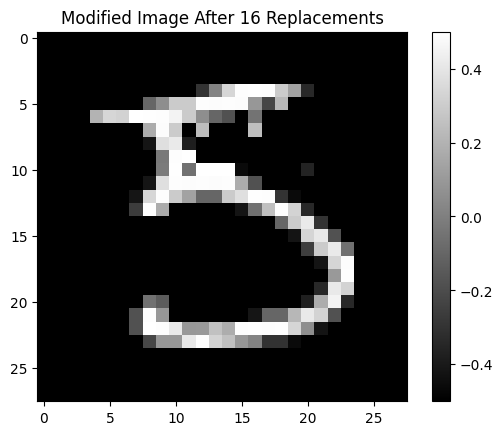

Predictions after each replacement:
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3]


In [43]:
import numpy as np
import matplotlib.pyplot as plt

def replace_pixels_using_shap(X, best_image, positive_shap_values_with_coords, cnn, target_label=3):
    """
    Iteratively replace pixels in X with those from best_image based on positive SHAP values (in descending order),
    and check the model's prediction after each replacement. Stores and prints prediction results.
    
    Arguments:
    - X: Original image (1D array, 784 elements)
    - best_image: Counterfactual image (1D array, 784 elements)
    - positive_shap_values_with_coords: List of positive SHAP values with their coordinates (sorted in descending order)
    - cnn: The model used for prediction
    - target_label: The target label to check (default = 3)
    
    Returns:
    - X_modified: Modified image after replacement
    - num_replacements: The number of pixels replaced to achieve the target prediction
    - predictions_array: List of prediction results after each replacement
    """

    X_modified = X.reshape(28, 28).copy()
    best_image_reshaped = best_image.reshape(28, 28)

    predictions_array = []  

    for rank, (value, (i, j)) in enumerate(positive_shap_values_with_coords):
        X_modified[i, j] = best_image_reshaped[i, j]
   
        prediction = cnn.predict(X_modified.reshape(1, 784))
        predicted_class = np.argmax(prediction)
        predictions_array.append(predicted_class) 

        if predicted_class == target_label:
            print(f"Target label {target_label} predicted after {rank + 1} replacements.")
            return X_modified, rank + 1, predictions_array  

    return X_modified, len(positive_shap_values_with_coords), predictions_array

X = X_tensor.cpu().numpy() 

X_modified, num_replacements, predictions_array = replace_pixels_using_shap(X, joint_max_image, positive_shap_values_with_coords, cnn)

plt.imshow(X_modified, cmap='gray')
plt.colorbar()
plt.title(f'Modified Image After {num_replacements} Replacements')
plt.show()

print("Predictions after each replacement:")
print(predictions_array)


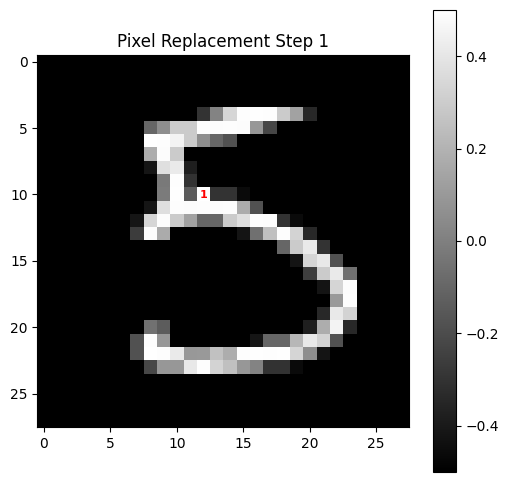

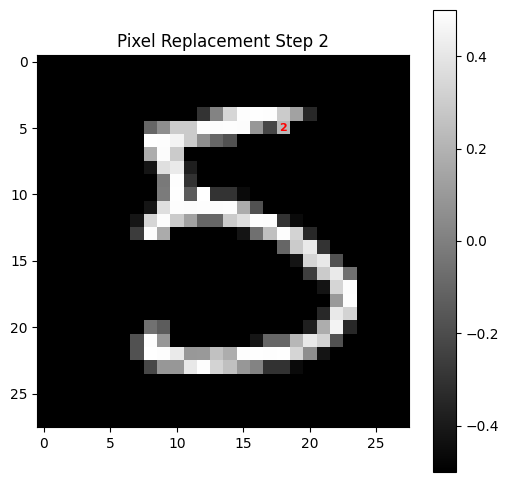

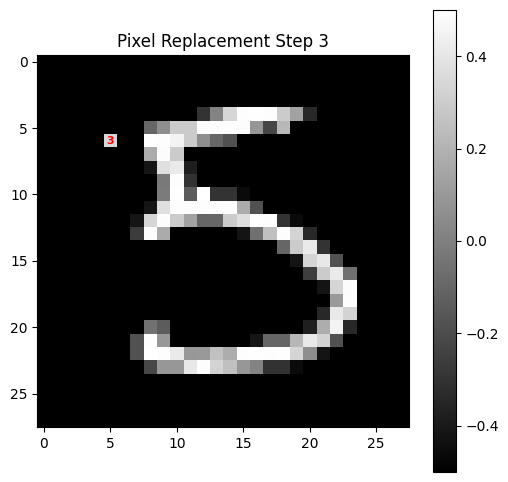

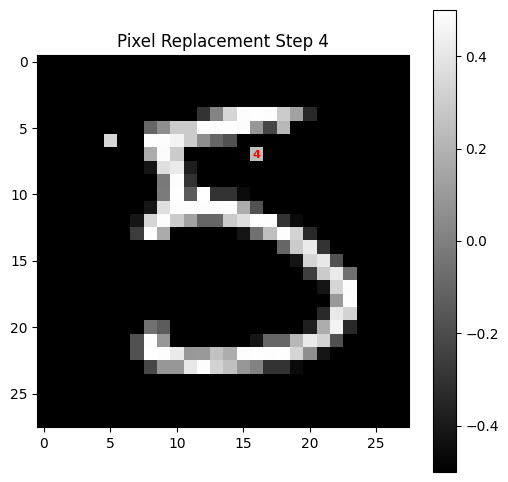

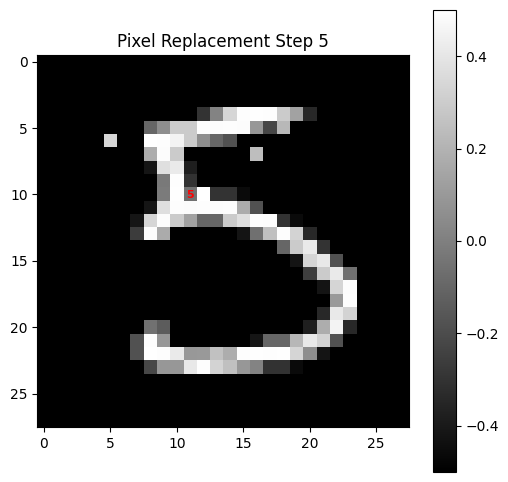

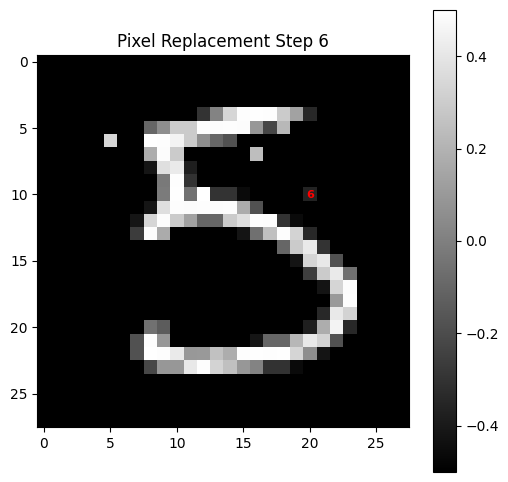

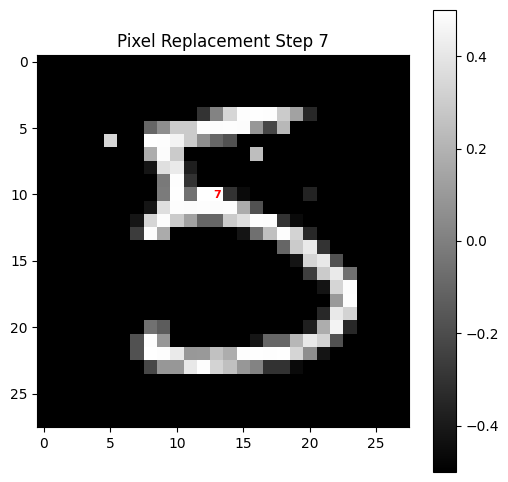

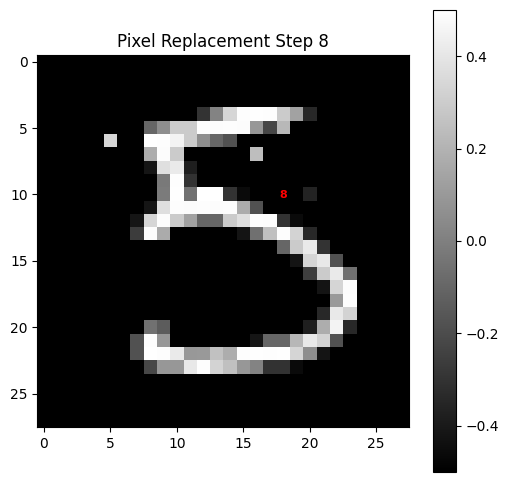

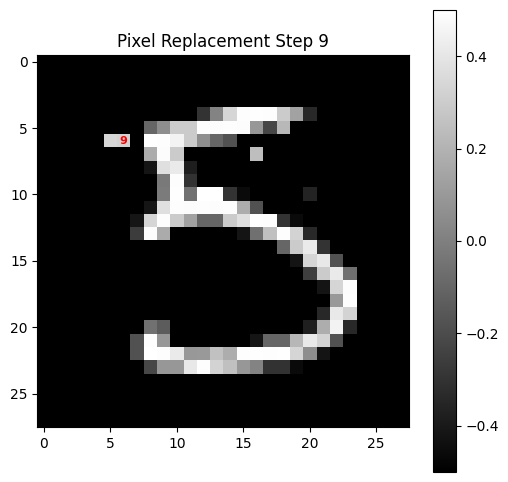

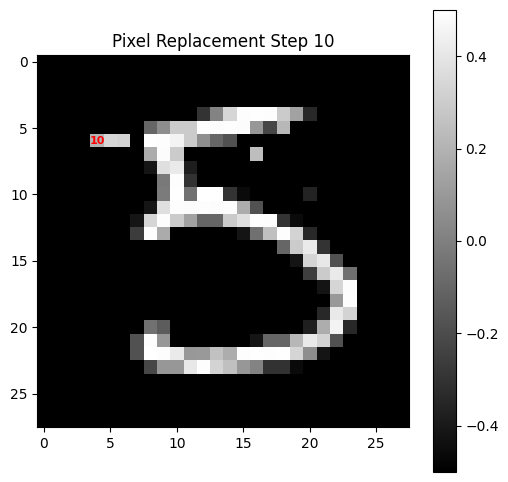

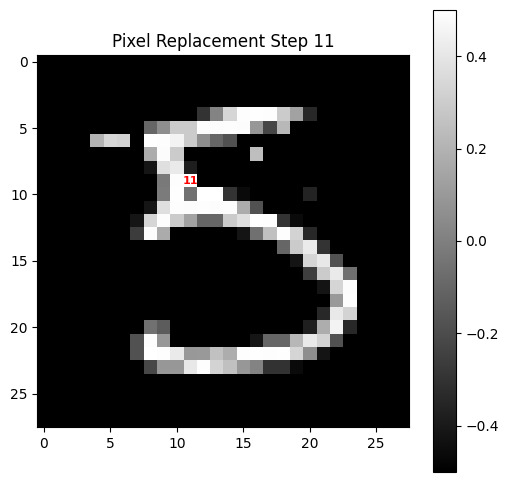

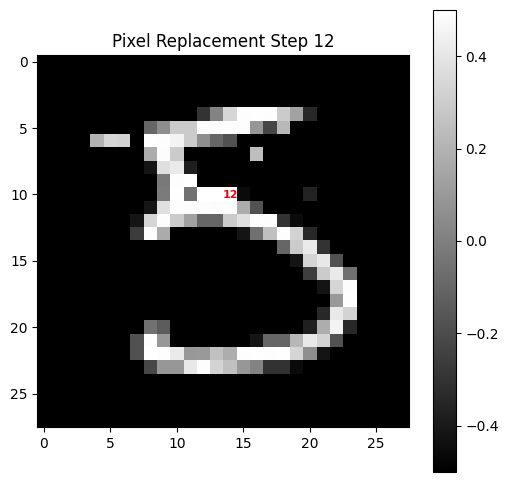

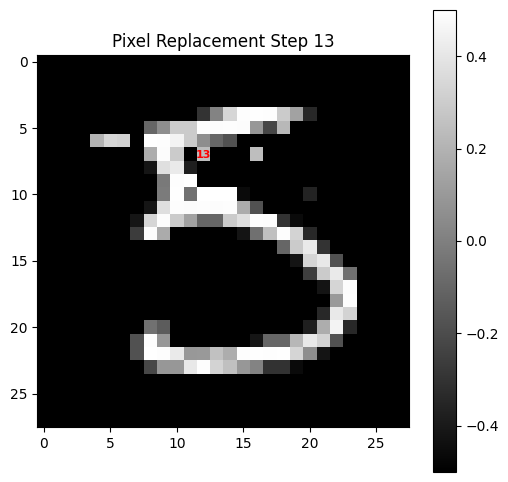

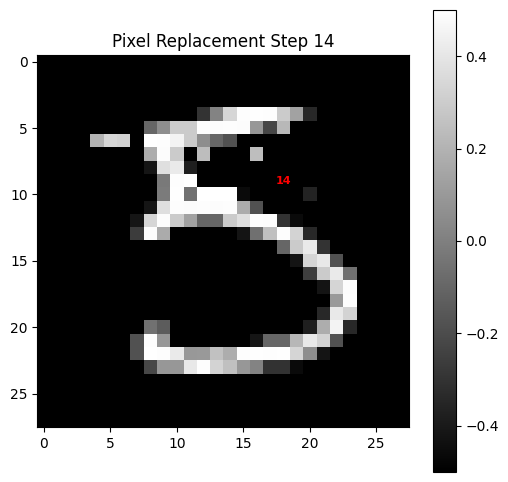

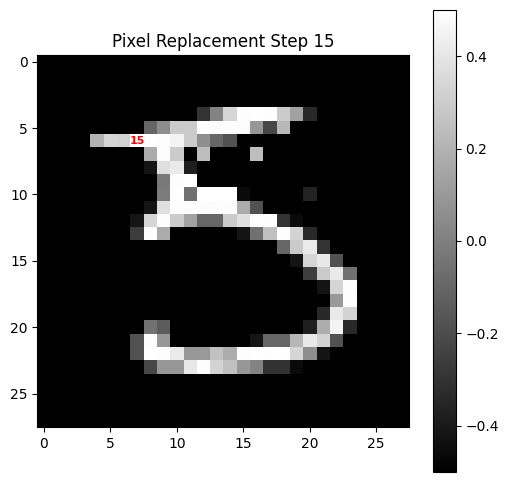

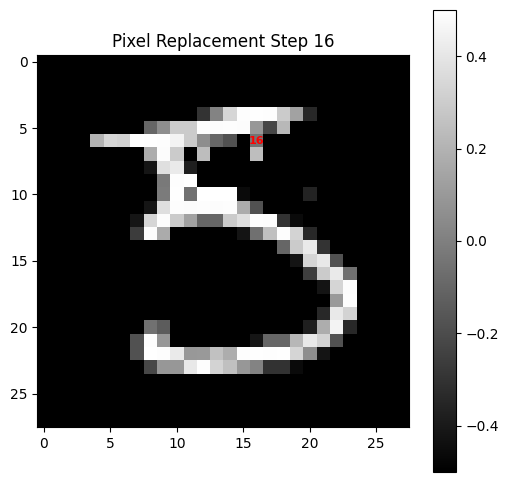

Successful with 16 replacements.


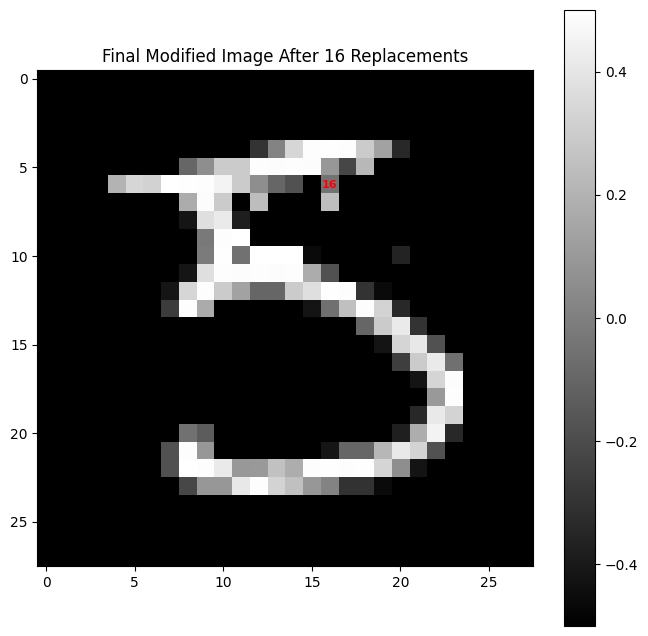

Coordinates of replaced pixels that achieved target prediction (with SHAP ranks):
[(15, (6, 16))]


In [45]:
import numpy as np
import matplotlib.pyplot as plt

def minimal_greedy_replacement(X, best_image, positive_shap_values_with_coords, cnn, target_label=3):
    """
    Greedy approach to find the minimal number of pixel replacements required to change the prediction to the target label.
    
    Arguments:
    - X: Original image (1D array, 784 elements)
    - best_image: Counterfactual image (1D array, 784 elements)
    - positive_shap_values_with_coords: List of positive SHAP values with their coordinates (sorted in descending order)
    - cnn: The model used for prediction
    - target_label: The target label to check (default = 3)
    
    Returns:
    - X_modified: Modified image after replacement
    - num_replacements: The number of pixels replaced to achieve the target prediction
    - successful_combination: List of pixel coordinates that achieved the target prediction
    """

    # Reshape the best image and original image
    X_modified = X.reshape(28, 28).copy()
    best_image_reshaped = best_image.reshape(28, 28)

    successful_combination = []
    found_successful = False

    # Incrementally replace pixels based on SHAP value ranking
    for rank, (value, (i, j)) in enumerate(positive_shap_values_with_coords):
        X_modified[i, j] = best_image_reshaped[i, j]  # Replace pixel

        # Plot the modified image at each step
        plt.figure(figsize=(6, 6))
        plt.imshow(X_modified, cmap='gray')
        plt.title(f'Pixel Replacement Step {rank + 1}')
        plt.colorbar()
        plt.text(j, i, f'{rank+1}', color='red', fontsize=8, ha='center', va='center', fontweight='bold')
        plt.show()

        # Check prediction after each replacement
        prediction = cnn.predict(X_modified.reshape(1, 784))
        predicted_class = np.argmax(prediction)

        # If target class is achieved, stop
        if predicted_class == target_label:
            found_successful = True
            successful_combination = [(rank, (i, j))]
            print(f"Successful with {rank + 1} replacements.")
            break

    if not found_successful:
        print("Target label not achieved even after replacing all pixels in ranked order.")
        num_replacements = len(positive_shap_values_with_coords)
    else:
        num_replacements = rank + 1  # Number of replacements made

    return X_modified, num_replacements, successful_combination

# Example usage
X = X_tensor.cpu().numpy()  # Convert tensor to numpy array if needed
X_modified, min_replacements, successful_combination = minimal_greedy_replacement(
    X, joint_max_image, positive_shap_values_with_coords, cnn, target_label=3
)

# Final Plot
plt.figure(figsize=(8, 8))
plt.imshow(X_modified, cmap='gray')
plt.colorbar()
plt.title(f'Final Modified Image After {min_replacements} Replacements')

# Overlay final successful combination pixel replacements with their SHAP rank
for rank, (i, j) in successful_combination:
    plt.text(j, i, f'{rank+1}', color='red', fontsize=8, ha='center', va='center', fontweight='bold')

plt.show()

print("Coordinates of replaced pixels that achieved target prediction (with SHAP ranks):")
print(successful_combination)


In [164]:
import shap
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

warnings.filterwarnings("ignore")

class WeightedExplainer:
    def __init__(self, model, target_class=2):  # Target class for SHAP (index 2 for class 3)
        self.model = model
        self.target_class = target_class

    def explain_instance(self, x, X_baseline, sample_size=20, shap_sample_size="auto"):
        # Sample baseline randomly without using weights
        indices = np.random.choice(X_baseline.shape[0], replace=True, size=sample_size)
        sampled_X_baseline = X_baseline[indices]

        # Define a prediction function for class 3 probability only
        def predict_class_3_prob(inputs):
            # Get predictions and select the probability for class 3
            return self.model.predict(inputs)[:, self.target_class]

        # Use KernelExplainer with the class-specific prediction function
        explainer_temp = shap.KernelExplainer(predict_class_3_prob, sampled_X_baseline)

        # Calculate SHAP values for each pixel for class 3
        shap_values = explainer_temp.shap_values(x, nsamples=shap_sample_size)
        return np.array(shap_values)  # Shape should be (784,)

# Instantiate the explainer for the CNN model
explainer = WeightedExplainer(cnn, target_class=2)  # Adjust target_class to the index of class 3

# Define the baseline as a single copy of X_flat
X_baseline = X_flat.reshape(1, -1)  # Shape: (1, 784)

# List to store SHAP values for each counterfactual
shap_values_list = []

# Iterate over each of the 15 counterfactual R images
for counterfactual_index in tqdm(range(10), desc="Calculating SHAP for Counterfactuals"):
    r_flat = np.copy(largest_distance_images_[counterfactual_index].flatten())  # Flatten the current counterfactual R
    
    # Calculate SHAP values for r_flat (for class 3 only)
    shap_values = explainer.explain_instance(r_flat, X_baseline, sample_size=200)
    print(f"shap_values shape for counterfactual {counterfactual_index}: {shap_values.shape}")
    
    # Multiply SHAP values by the corresponding joint probability for this counterfactual
    weighted_shap_values = shap_values * joint_probabilities[counterfactual_index]
    
    # Append the weighted SHAP values to shap_values_list
    shap_values_list.append(weighted_shap_values)

# Compute the mean SHAP values across all 15 counterfactual images
final_weighted_shap_values = np.mean(shap_values_list, axis=0)  # Shape: (784,)

# Print the maximum weighted SHAP value for reference
print(f"Maximum weighted SHAP value: {np.max(final_weighted_shap_values)}")

# Visualize the final weighted SHAP values as a 28x28 heatmap
plt.imshow(final_weighted_shap_values.reshape(28, 28), cmap='hot')
plt.colorbar()
plt.title('Weighted p-SHAP Values (Class 3, Using All 10 R Images)')
plt.show()


Calculating SHAP for Counterfactuals:  10%|█         | 1/10 [02:32<22:49, 152.14s/it]Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


shap_values shape for counterfactual 0: (784,)


Calculating SHAP for Counterfactuals:  10%|█         | 1/10 [03:50<34:31, 230.22s/it]


KeyboardInterrupt: 

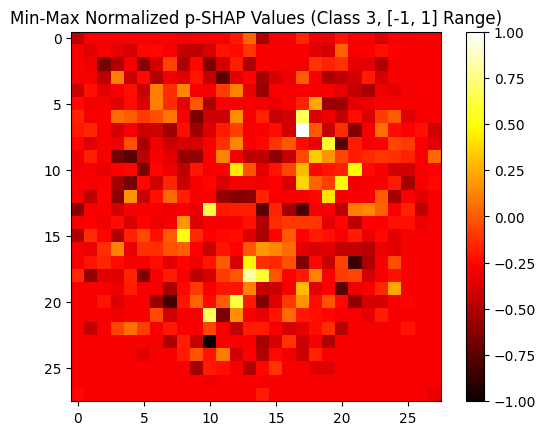

In [132]:
# Min-Max normalization to scale between -1 and 1
min_val = np.min(final_weighted_shap_values)
max_val = np.max(final_weighted_shap_values)
normalized_shap_values = 2 * (final_weighted_shap_values - min_val) / (max_val - min_val) - 1

# Visualization of normalized SHAP values
plt.imshow(normalized_shap_values.reshape(28, 28), cmap='hot')
plt.colorbar()
plt.title('Min-Max Normalized p-SHAP Values (Class 3, [-1, 1] Range)')
plt.show()


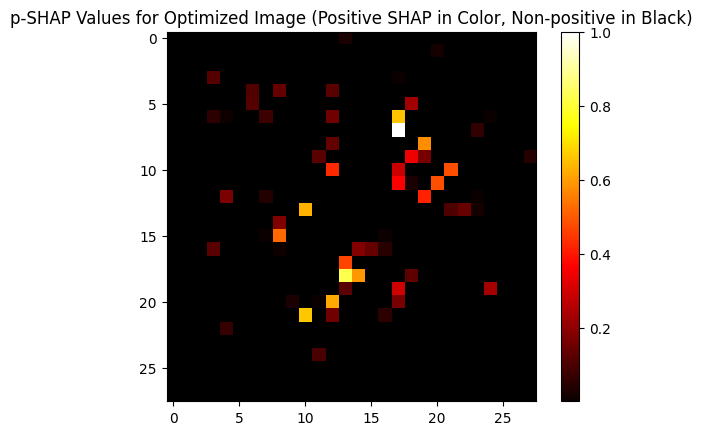

In [145]:
masked_p_shap_values = np.copy(normalized_shap_values.reshape(28,28))
masked_p_shap_values[masked_p_shap_values <= 0] = np.nan  

cmap = plt.get_cmap('hot')
cmap.set_bad(color='black')  

plt.imshow(masked_p_shap_values, cmap=cmap, interpolation='none')
plt.colorbar()
plt.title('p-SHAP Values for Optimized Image (Positive SHAP in Color, Non-positive in Black)')
plt.show()

In [133]:
sorted_shap_values = np.sort(normalized_shap_values, axis=None)[::-1] 

sorted_indices = np.argsort(normalized_shap_values, axis=None)[::-1]  

coordinates = np.unravel_index(sorted_indices, (28, 28)) 

sorted_shap_with_coords = list(zip(sorted_shap_values, zip(coordinates[0], coordinates[1])))

positive_shap_values_with_coords = [(value, coord) for value, coord in sorted_shap_with_coords if value>0]
print(positive_shap_values_with_coords)

for value, coord in positive_shap_values_with_coords:
    print(f"SHAP value: {value:.6f}, Coordinate: {coord}")


[(1.0, (7, 17)), (0.8230966228414422, (18, 13)), (0.6642571659166516, (21, 10)), (0.6601814821341683, (6, 17)), (0.6321393736564562, (13, 10)), (0.6210876805992283, (20, 12)), (0.5925204970058962, (18, 14)), (0.5778537272035325, (8, 19)), (0.5211425570791308, (15, 8)), (0.48415563895479274, (11, 20)), (0.4820378767265241, (10, 21)), (0.46825037782873835, (17, 13)), (0.4270935226337773, (10, 12)), (0.41585019356094777, (12, 19)), (0.36363068818636557, (11, 17)), (0.34086245096809176, (9, 18)), (0.2966169768845177, (19, 17)), (0.2873316600955471, (10, 17)), (0.23185619610116293, (19, 24)), (0.23056942743078368, (5, 18)), (0.18311579521319432, (16, 14)), (0.177919245789669, (14, 8)), (0.17089912839368315, (12, 4)), (0.16488275835098198, (20, 17)), (0.1643955227503442, (9, 19)), (0.15544643707962047, (6, 12)), (0.15527820581126694, (21, 12)), (0.14389237466038374, (13, 22)), (0.1401509017801732, (4, 8)), (0.13942694981550074, (16, 15)), (0.13490797685969702, (8, 12)), (0.1276716394851487, 

In [130]:
np.array(positive_shap_values_with_coords).shape

(46, 2)

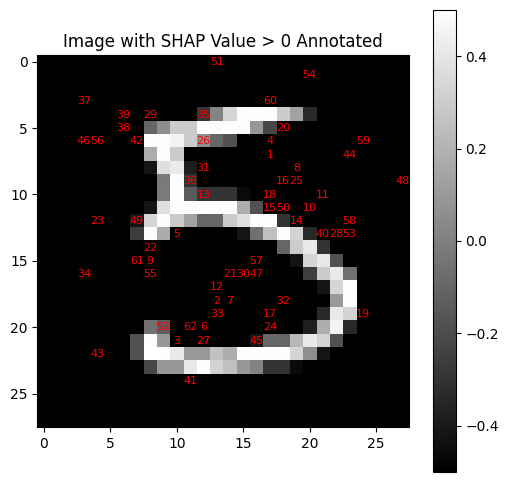

In [134]:
plt.figure(figsize=(6, 6))
plt.imshow(X_reshaped, cmap='gray', interpolation='none')
plt.title('Image with SHAP Value > 0 Annotated')

for rank, (value, (i, j)) in enumerate(positive_shap_values_with_coords):
    plt.text(j, i, str(rank + 1), color='red', fontsize=8, ha='center', va='center') 

plt.colorbar()
plt.show()


Target label 3 not achieved within 20 pixel combinations.


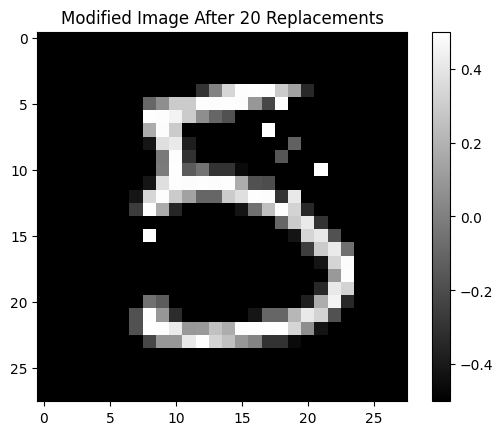

Coordinates of replaced pixels that achieved target prediction:
[(7, 17), (18, 13), (21, 10), (6, 17), (13, 10), (20, 12), (18, 14), (8, 19), (15, 8), (11, 20), (10, 21), (17, 13), (10, 12), (12, 19), (11, 17), (9, 18), (19, 17), (10, 17), (19, 24), (5, 18)]


In [143]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

def minimal_combination_replacement(X, best_image, positive_shap_values_with_coords, cnn, target_label=3, max_pixels=10):
    """
    Finds the minimal number of pixel replacements required to change the prediction to the target label.
    
    Arguments:
    - X: Original image (1D array, 784 elements)
    - best_image: Counterfactual image (1D array, 784 elements)
    - positive_shap_values_with_coords: List of positive SHAP values with their coordinates (sorted in descending order)
    - cnn: The model used for prediction
    - target_label: The target label to check (default = 3)
    - max_pixels: Maximum number of top SHAP value pixels to consider for combination testing
    
    Returns:
    - X_modified: Modified image after replacement
    - min_replacements: The minimum number of pixels replaced to achieve the target prediction
    - successful_combination: List of pixel coordinates that achieved the target prediction
    """

    # Reshape original and best images
    X_modified = X.reshape(28, 28).copy()
    best_image_reshaped = best_image.reshape(28, 28)

    # Limit to the top `max_pixels` SHAP values for efficiency
    top_pixels = positive_shap_values_with_coords[:max_pixels]

    # Test combinations of pixel replacements in increasing order
    for num_replacements in range(1, max_pixels + 1):
        # Generate all combinations of the current size
        for pixel_indices in combinations(top_pixels, num_replacements):
            # Temporarily modify the image based on the current combination
            temp_image = X_modified.copy()
            for _, (i, j) in pixel_indices:
                temp_image[i, j] = best_image_reshaped[i, j]

            # Predict with the modified image
            prediction = cnn.predict(temp_image.reshape(1, 784))
            predicted_class = np.argmax(prediction)

            # Check if the target label is achieved
            if predicted_class == target_label:
                print(f"Target label {target_label} predicted with {num_replacements} replacements.")
                successful_combination = [(i, j) for _, (i, j) in pixel_indices]
                return temp_image, num_replacements, successful_combination

    # If no combination achieves the target, return the original image and all top pixels replaced
    print(f"Target label {target_label} not achieved within {max_pixels} pixel combinations.")
    for _, (i, j) in top_pixels:
        X_modified[i, j] = best_image_reshaped[i, j]
    return X_modified, max_pixels, [coords for _, coords in top_pixels]

# Example usage
X = X_tensor.cpu().numpy()  # Convert tensor to numpy array if needed
X_modified, min_replacements, successful_combination = minimal_combination_replacement(
    X, best_image, positive_shap_values_with_coords, cnn, target_label=3, max_pixels=20
)

# Display the final modified image
plt.imshow(X_modified, cmap='gray')
plt.colorbar()
plt.title(f'Modified Image After {min_replacements} Replacements')
plt.show()

# Print the successful combination of pixels
print("Coordinates of replaced pixels that achieved target prediction:")
print(successful_combination)


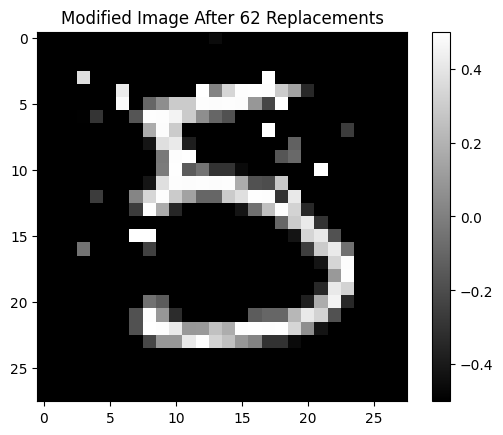

Predictions after each replacement:
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


In [139]:
import numpy as np
import matplotlib.pyplot as plt

def replace_pixels_using_shap(X, best_image, positive_shap_values_with_coords, cnn, target_label=3):
    """
    Iteratively replace pixels in X with those from best_image based on positive SHAP values (in descending order),
    and check the model's prediction after each replacement. Stores and prints prediction results.
    
    Arguments:
    - X: Original image (1D array, 784 elements)
    - best_image: Counterfactual image (1D array, 784 elements)
    - positive_shap_values_with_coords: List of positive SHAP values with their coordinates (sorted in descending order)
    - cnn: The model used for prediction
    - target_label: The target label to check (default = 3)
    
    Returns:
    - X_modified: Modified image after replacement
    - num_replacements: The number of pixels replaced to achieve the target prediction
    - predictions_array: List of prediction results after each replacement
    """

    X_modified = X.reshape(28, 28).copy()
    best_image_reshaped = best_image.reshape(28, 28)

    predictions_array = []  

    for rank, (value, (i, j)) in enumerate(positive_shap_values_with_coords):
        X_modified[i, j] = best_image_reshaped[i, j]
   
        prediction = cnn.predict(X_modified.reshape(1, 784))
        predicted_class = np.argmax(prediction)
        predictions_array.append(predicted_class) 

        if predicted_class == target_label:
            print(f"Target label {target_label} predicted after {rank + 1} replacements.")
            return X_modified, rank + 1, predictions_array  

    return X_modified, len(positive_shap_values_with_coords), predictions_array

X = X_tensor.cpu().numpy() 

X_modified, num_replacements, predictions_array = replace_pixels_using_shap(X, best_image, positive_shap_values_with_coords, cnn)

plt.imshow(X_modified, cmap='gray')
plt.colorbar()
plt.title(f'Modified Image After {num_replacements} Replacements')
plt.show()

print("Predictions after each replacement:")
print(predictions_array)


31


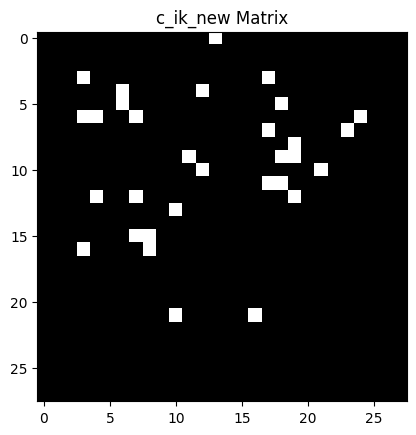

3


In [140]:
c_ik_cp = np.where(X_tensor.numpy().reshape(28,28) != X_modified.reshape(28,28), 1, 0)
changed_pixel_opti = np.sum(c_ik_cp)
print(changed_pixel_opti)
plt.imshow(c_ik_cp.reshape(28,28),cmap='gray')
plt.title('c_ik_new Matrix')
plt.show()
print(cnn.predict(PN_optimized1.reshape(1,784)).argmax())